In [1]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# nltk.download('stopwords')  # شغّلها مرة واحدة فقط
from nltk.corpus import stopwords

# --- Step 2: Load news.tsv ---
news_path = "../data/news.tsv"  # غيّر المسار حسب هيكل المشروع

columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
news_df = pd.read_csv(news_path, sep='\t', names=columns)

print(f"Loaded {len(news_df)} news articles.")
news_df.head()


Loaded 51282 news articles.


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [2]:
# --- Step 3: Combine title and abstract into one text field ---
news_df['content'] = news_df['title'].fillna('') + ' ' + news_df['abstract'].fillna('')


In [3]:
# --- Step 4: Text Cleaning Function ---
def clean_text(text):
    text = text.lower()                            # lowercase
    text = re.sub(r'\d+', '', text)                # remove digits
    text = re.sub(r'[^\w\s]', '', text)            # remove punctuation
    text = re.sub(r'\s+', ' ', text)               # remove extra spaces
    text = text.strip()
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply cleaning
news_df['clean_content'] = news_df['content'].apply(clean_text).apply(remove_stopwords)
news_df[['content', 'clean_content']].head()


,content,clean_content
0,"The Brands Queen Elizabeth, Prince Charles, an...",brands queen elizabeth prince charles prince p...
1,50 Worst Habits For Belly Fat These seemingly ...,worst habits belly fat seemingly harmless habi...
2,The Cost of Trump's Aid Freeze in the Trenches...,cost trumps aid freeze trenches ukraines war l...
3,I Was An NBA Wife. Here's How It Affected My M...,nba wife heres affected mental health felt lik...
4,"How to Get Rid of Skin Tags, According to a De...",get rid skin tags according dermatologist seem...


In [4]:
# --- Step 5: Extract TF-IDF features ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # يمكنك زيادة أو تقليل عدد الميزات

tfidf_matrix = tfidf_vectorizer.fit_transform(news_df['clean_content'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (51282, 5000)


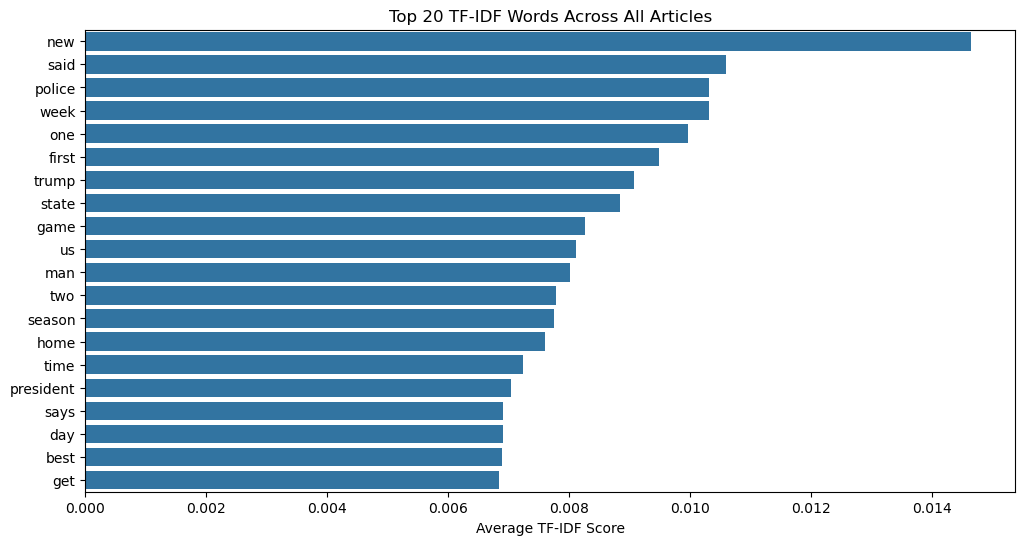

In [5]:
# --- (اختياري) Step 6: Visualize Most Common Words ---
# Get feature names and average scores
feature_array = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_means = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Top 20 words
top_indices = tfidf_means.argsort()[-20:][::-1]
top_words = feature_array[top_indices]
top_scores = tfidf_means[top_indices]

plt.figure(figsize=(12,6))
sns.barplot(x=top_scores, y=top_words)
plt.title("Top 20 TF-IDF Words Across All Articles")
plt.xlabel("Average TF-IDF Score")
plt.show()


In [6]:
# Save cleaned data and tf-idf matrix
news_df.to_pickle("../data/cleaned_news_df.pkl")

from scipy import sparse
sparse.save_npz("../data/tfidf_matrix.npz", tfidf_matrix)

# Save vectorizer to reuse it
import pickle
with open("../data/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
